In [3]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib

## 이미지 로드

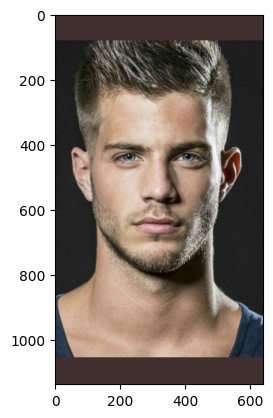

In [4]:
original_image = cv2.imread("images/sample1.png")
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
plt.imshow(original_image)

### 얼굴 탐지

In [5]:
detector_hog = dlib.get_frontal_face_detector()
face_rects = detector_hog(original_image, 1)

for rect in face_rects:
    print(rect)

[(118, 333) (504, 718)]


### 랜드마크 탐지

In [6]:
landmark_predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

face_landmarks = []
for rect in face_rects:
    landmark = landmark_predictor(original_image, rect)
    face_landmarks.append(landmark)

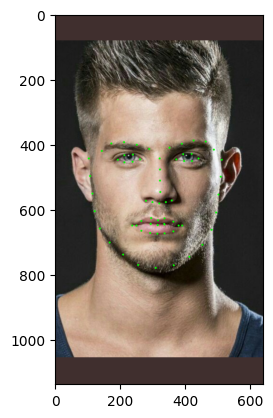

In [7]:
temp_image = original_image.copy()

for landmark in face_landmarks:
    for i in range(landmark.num_parts):
        point = landmark.part(i)
        cv2.circle(temp_image, (point.x, point.y), 3, (0, 255, 0), -1)

plt.imshow(temp_image)

### 얼굴에 스티커 붙이기

In [8]:
def add_sticker(image, face_rects, face_landmarks, debug=False):
    image = image.copy()
    image_height, image_width = image.shape[:2]

    for rect, landmark in zip(face_rects, face_landmarks):
        # 1. 얼굴 크기에 맞게 스티커 이미지를 resize
        face_width = rect.width()
        face_height = rect.height()
        sticker_image = cv2.imread("images/sticker.png")
        resized_sticker_width = min(face_width, face_height)
        sticker_image = cv2.resize(sticker_image, (resized_sticker_width, resized_sticker_width))

        # 2. 코 위치에 스티커 위치를 올긴다
        sticker_image_height, sticker_image_width = sticker_image.shape[:2]
        nose_point = landmark.part(33) # 코 위치 (참고: face_landmark.png)
        sticker_image_x = nose_point.x - sticker_image_width // 2
        sticker_image_y = nose_point.y - sticker_image_height // 2

        # 3. 스티커 그리기
        # 스티커 위쪽이 벗어나는 경우
        if sticker_image_y < 0:
            sticker_image = sticker_image[-sticker_image_y:, :]
            sticker_image_y = 0

        # 스티커 아래가 벗어나는 경우
        sticker_image_y_to = sticker_image_y + sticker_image.shape[0]
        if image_height < sticker_image_y_to:
            sticker_image = sticker_image[:image_height - sticker_image_y, :]
            sticker_image_y_to = image_height

        # 스티커 왼쪽이 벗어나는 경우
        if sticker_image_x < 0:
            sticker_image = sticker_image[:, -sticker_image_x:]
            sticker_image_x = 0

        # 스티커 오른쪽이 벗어나는 경우
        sticker_image_x_to = sticker_image_x + sticker_image.shape[1]
        if image_width < sticker_image_x_to:
            sticker_image = sticker_image[:, :image_width - sticker_image_x]
            sticker_image_x_to = image_width

        mask_area = image[
            sticker_image_y:sticker_image_y_to,
            sticker_image_x:sticker_image_x_to
        ]
        sticker_mask = np.where(sticker_image == 255, mask_area, sticker_image).astype(np.uint8)

        image[
            sticker_image_y:sticker_image_y_to,
            sticker_image_x:sticker_image_x_to
        ] = sticker_mask

        if debug:
            cv2.rectangle(image, (rect.left(),rect.top()), (rect.right(),rect.bottom()), (0,255,0), 2, lineType=cv2.LINE_AA) # 시작점의 좌표와 종료점 좌표로 직각 사각형을 그림
            cv2.circle(image, (nose_point.x, nose_point.y), 2, (0, 255, 0), -1) # 코의 위치
            cv2.circle(image, (sticker_image_x, sticker_image_y), 2, (255, 0, 0), -1)

    return image

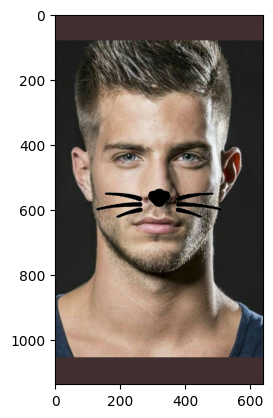

In [9]:
plt.imshow(add_sticker(original_image, face_rects, face_landmarks))

### 여러 이미지로 테스트

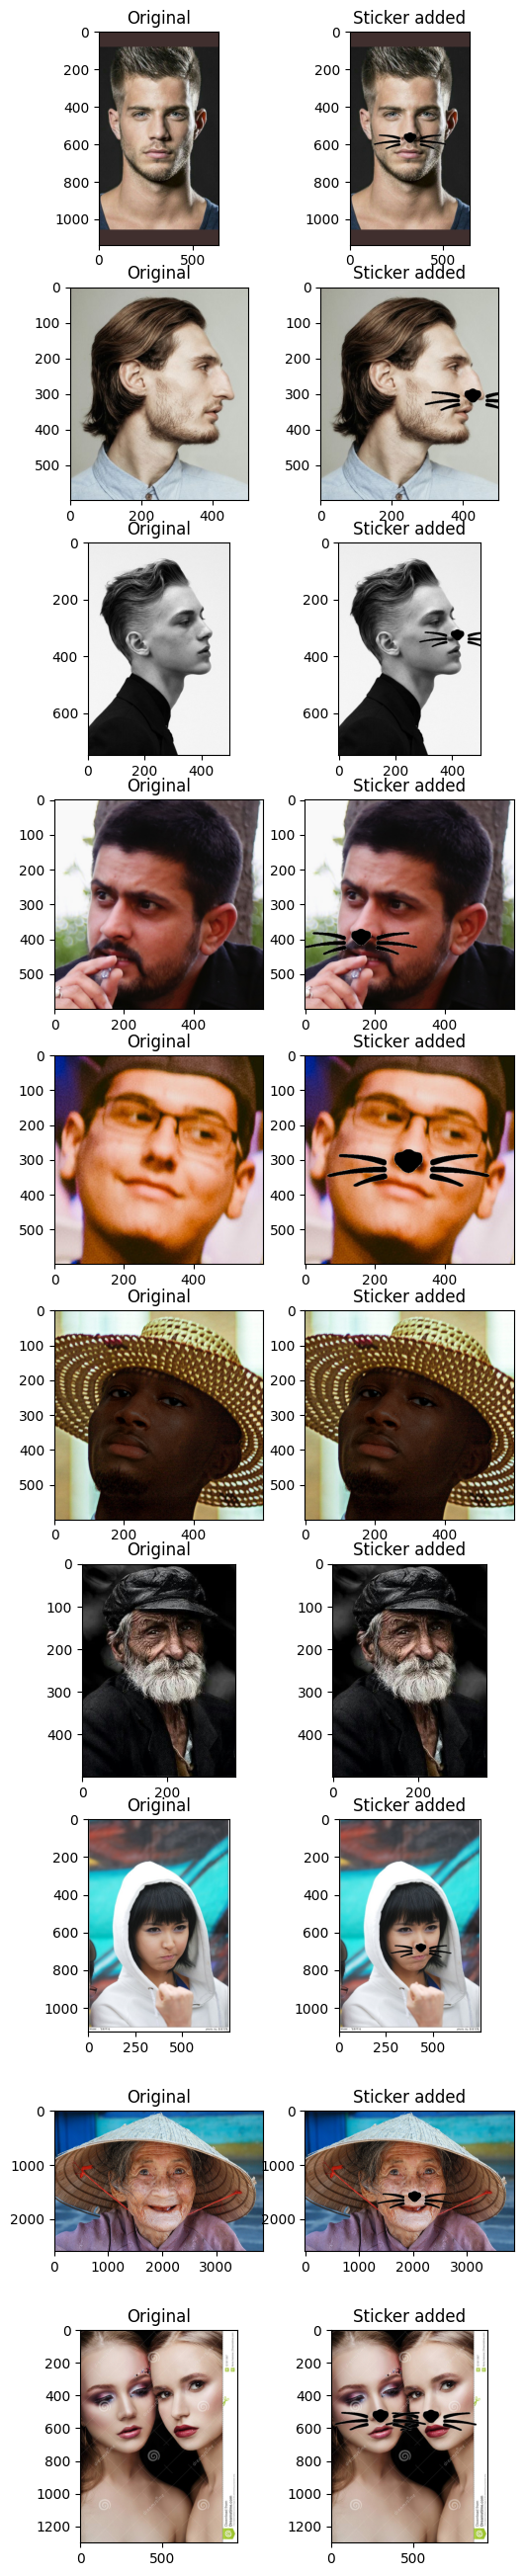

In [37]:
plt.figure(figsize=(6, 33))

count = 1

for i in range(1, 11):
    sample_image = cv2.imread(f"images/sample{i}.png")
    sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
    face_rects = detector_hog(sample_image, 1)
    face_landmarks = [landmark_predictor(sample_image, rect) for rect in face_rects]

    sticker_added_image = add_sticker(sample_image, face_rects, face_landmarks)

    plt.subplot(10, 2, count)
    plt.imshow(sample_image)
    plt.title(f"Original")
    count += 1

    plt.subplot(10, 2, count)
    plt.imshow(sticker_added_image)
    plt.title(f"Sticker added")
    count += 1

### 회전된 이미지로 테스트

- 이미지가 회전 되면 얼굴 감지를 하지 못하였다.
- 테스트 한 바로는 약 45 정도 까지만 인식한다.

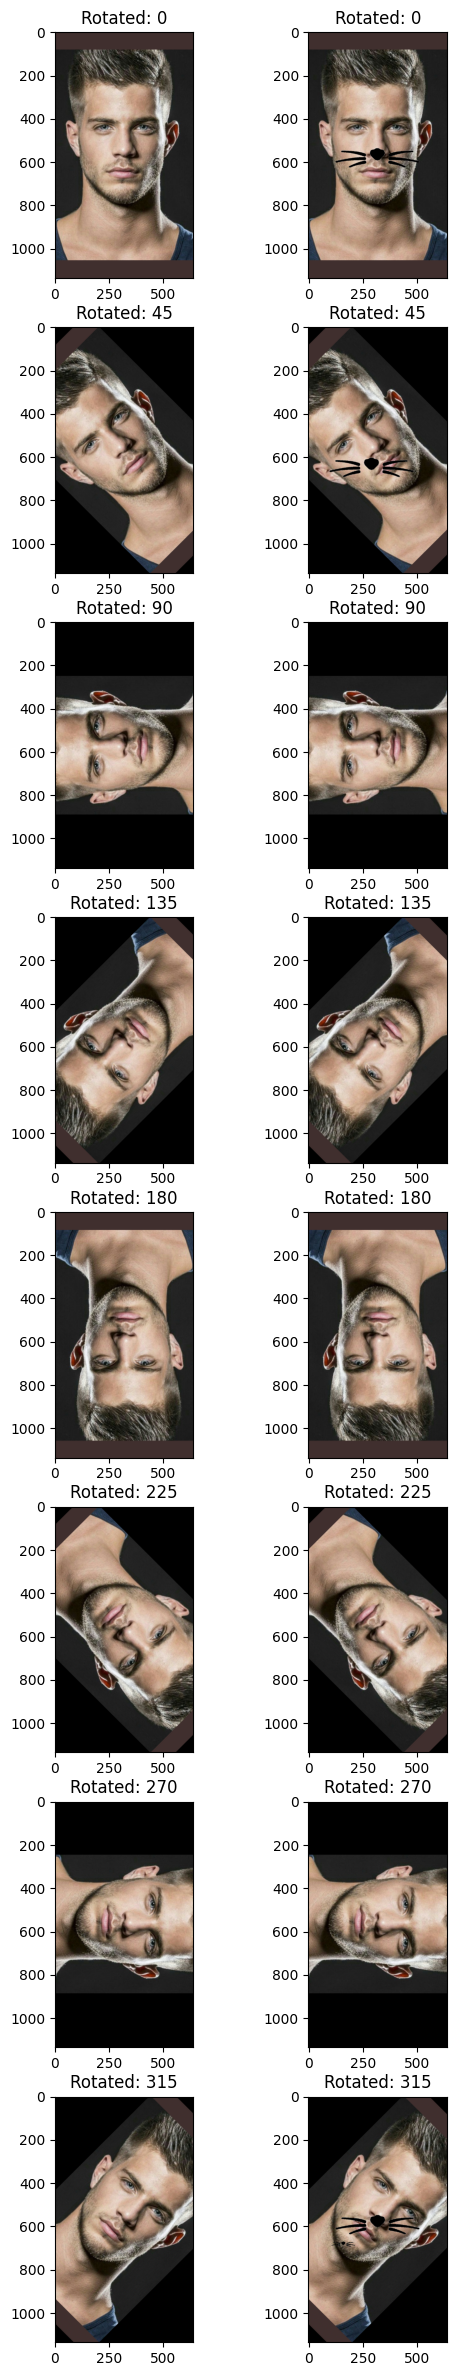

In [11]:
def rotate(image, angle):
    h, w = image.shape[:2]
    center = (w // 2, h // 2)
    scale = 1.0
    M = cv2.getRotationMatrix2D(center, angle, scale)

    # 회전 적용
    return cv2.warpAffine(image, M, (w, h))


plt.figure(figsize=(6, 30))

sample_image = cv2.imread(f"images/sample1.png")
sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)

count = 1

for angle in range(0, 360, 45):
    rotated_image = rotate(sample_image, angle)    
    face_rects = detector_hog(rotated_image, 1)
    face_landmarks = [landmark_predictor(rotated_image, rect) for rect in face_rects]
    sticker_added_image = add_sticker(rotated_image, face_rects, face_landmarks)

    plt.subplot(8, 2, count)
    plt.imshow(rotated_image)
    plt.title(f"Rotated: {angle}")
    count += 1

    plt.subplot(8, 2, count)
    plt.imshow(sticker_added_image)
    plt.title(f"Rotated: {angle}")
    count += 1


### 밝기를 다르게해서 테스트

- 밝기에 따라 너무 어둡거나 너무 밝으면 얼굴 감지를 하지 못하였다.

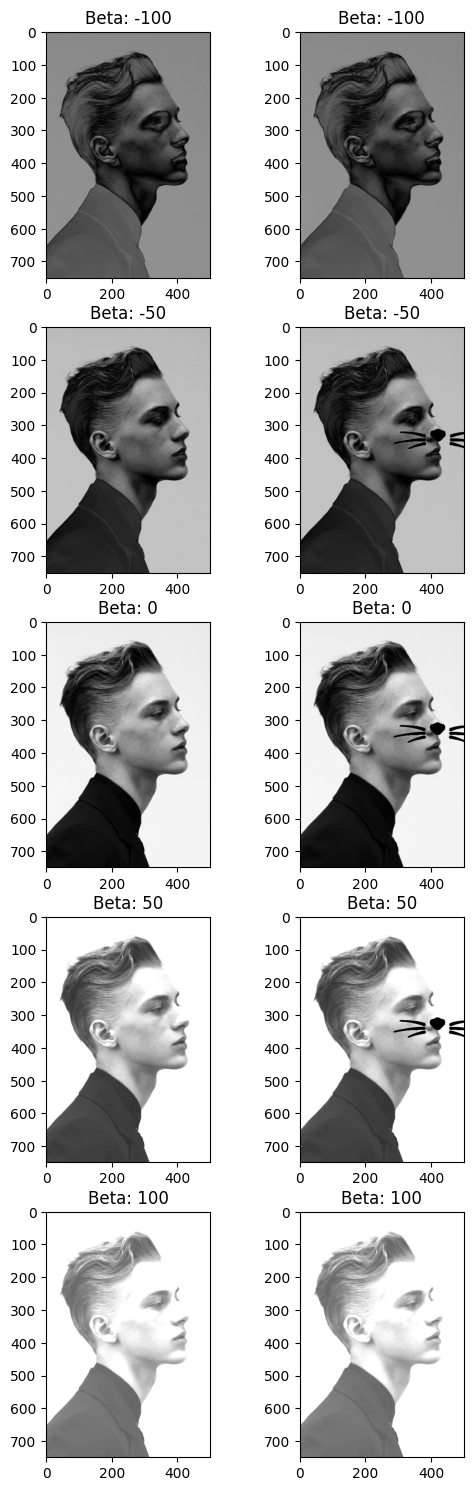

In [32]:
sample_image = cv2.imread(f"images/sample3.png")
sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(6, 30))
count = 1

for beta in range(-100, 101, 50):
    adjusted_image = cv2.convertScaleAbs(sample_image, alpha=1, beta=beta)
    face_rects = detector_hog(adjusted_image, 1)
    face_landmarks = [landmark_predictor(adjusted_image, rect) for rect in face_rects]
    sticker_added_image = add_sticker(adjusted_image, face_rects, face_landmarks)

    plt.subplot(8, 2, count)
    plt.imshow(adjusted_image)
    plt.title(f"Beta: {beta}")
    count += 1

    plt.subplot(8, 2, count)
    plt.imshow(sticker_added_image)
    plt.title(f"Beta: {beta}")
    count += 1


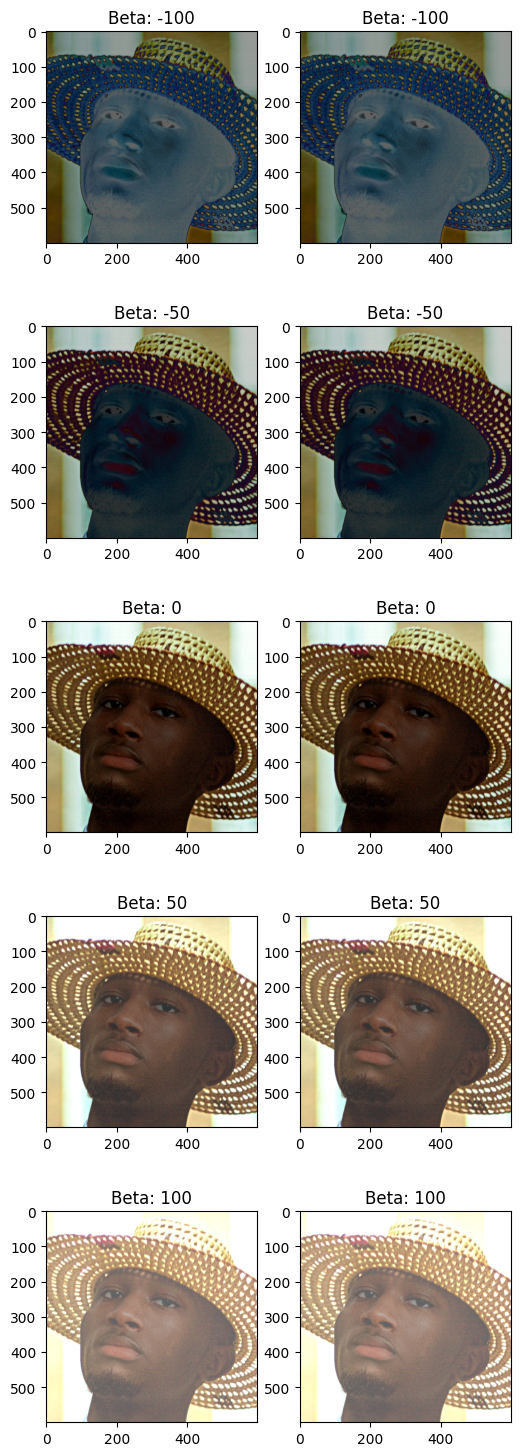

In [34]:
# 얼굴 검출이 안된 이미지 테스트 - 조명이 어두워서 인식이 안된 것인지?

sample_image = cv2.imread(f"images/sample6.png")
sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(6, 30))
count = 1

for beta in range(-100, 101, 50):
    adjusted_image = cv2.convertScaleAbs(sample_image, alpha=1, beta=beta)
    face_rects = detector_hog(adjusted_image, 1)
    face_landmarks = [landmark_predictor(adjusted_image, rect) for rect in face_rects]
    sticker_added_image = add_sticker(adjusted_image, face_rects, face_landmarks)

    plt.subplot(8, 2, count)
    plt.imshow(adjusted_image)
    plt.title(f"Beta: {beta}")
    count += 1

    plt.subplot(8, 2, count)
    plt.imshow(sticker_added_image)
    plt.title(f"Beta: {beta}")
    count += 1
